In [23]:
import torch
import matplotlib.pyplot as plt
import torch.utils as utils

In [24]:
#IMPORT MNIST DIGIT DATASET
from torchvision import datasets, transforms

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data = datasets.MNIST('data', train=True, download=True, transform=transform)
# split the data into training and validation datasets
seed_value = 42
generator = torch.Generator()
generator.manual_seed(seed_value)

training_data, validation_data = utils.data.random_split(data, [50000, 10000],generator=generator)

test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

In [26]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

In [27]:
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [28]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Sigmoid() ## using sigmoid activation function, because when we
        ## are normalizing the pixel values to the range of -1 to 1 , we wouldn't want to lose the negative values
        self.conv1 = torch.nn.Conv2d(1, 32, 3,1)
        self.conv2 = torch.nn.Conv2d(32,64,3,1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.maxpool1 = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)


    def forward(self, x):
        x = self.activation(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [29]:
net = Net()

# check for gpu and compute on it if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)



Net(
  (activation): Sigmoid()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [36]:
#TRAINING
num_epochs = 15
train_loss_history = list()
val_loss_history = list()


for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for i, (inputs,targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        outputs = outputs.to(device)
        #print(f'inputs.shape {inputs.shape}, outputs.shape {outputs.shape}')
        loss = loss_fn(outputs, targets)
        loss.backward() # this is where the model learns by backpropagating
        optimizer.step() # this is where the model optimizes its weights
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == targets).sum().item()
        train_total += targets.size()[0]
    print(f'Epoch {epoch + 1} training accuracy: {((train_correct/train_total*1.0)*100)}% training loss: {train_loss/len(train_loader):.5f}')
    scheduler.step()
    train_loss_history.append(train_loss/len(train_loader))
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    net.eval()
    for inputs, labels in validation_loader:
        inputs,labels = inputs.to(device),labels.to(device)
        outputs = net(inputs)
        outputs = outputs.to(device)
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size()[0]
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {((val_correct/val_total*1.0)*100)}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 99.514% training loss: 0.01665
Epoch 1 validation accuracy: 98.18% validation loss: 0.07115
Epoch 2 training accuracy: 99.502% training loss: 0.01646
Epoch 2 validation accuracy: 98.19% validation loss: 0.07098
Epoch 3 training accuracy: 99.48599999999999% training loss: 0.01626
Epoch 3 validation accuracy: 98.18% validation loss: 0.07203
Epoch 4 training accuracy: 99.53% training loss: 0.01590
Epoch 4 validation accuracy: 98.18% validation loss: 0.07208
Epoch 5 training accuracy: 99.48% training loss: 0.01660
Epoch 5 validation accuracy: 98.18% validation loss: 0.07097
Epoch 6 training accuracy: 99.52600000000001% training loss: 0.01619
Epoch 6 validation accuracy: 98.18% validation loss: 0.07127
Epoch 7 training accuracy: 99.516% training loss: 0.01620
Epoch 7 validation accuracy: 98.18% validation loss: 0.07169
Epoch 8 training accuracy: 99.544% training loss: 0.01564
Epoch 8 validation accuracy: 98.17% validation loss: 0.07101
Epoch 9 training accuracy: 9

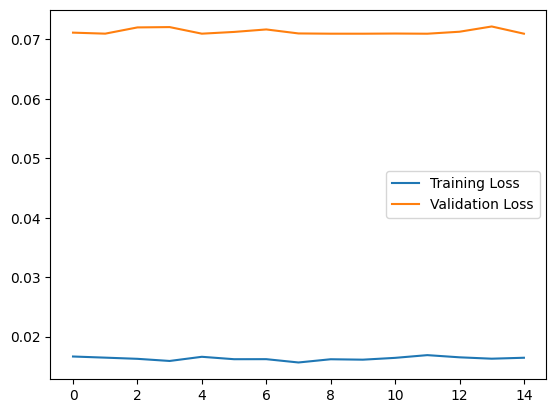

In [37]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()


In [38]:
test_loss = 0.0
test_correct = 0
test_total = 0
for inputs, labels in test_loader:
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = net(inputs).to(device)
    loss = loss_fn(outputs, labels)


    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()
    test_total += labels.size()[0]
    test_loss += loss.item()
print(f'Model Test accuracy: {((test_correct/test_total*1.0)*100)}% test loss: {test_loss/len(test_loader):.5f}')

Model Test accuracy: 98.29% test loss: 0.06714
